In [59]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score



# Load the dataset
df = pd.read_csv("data.csv")

We see that all males have value 97 for pregnancy because it is missing. Given that males cannot get pregnant, we will change all 97's in PREGNANT to 2. Some females have 98 which is a missing value, so we change all the 98's in PREGNANT to NAN. Currently 1 represents True and 2 represents False. To change the boolean values to the conventional way, we change the 2's to 0's.

In [60]:
df.loc[:, 'PREGNANT'] = df.loc[:, 'PREGNANT'].replace(97, 2)
df.loc[:, 'PREGNANT'] = df.loc[:, 'PREGNANT'].replace(98, np.NAN)
df.loc[:, 'PREGNANT'] = df.loc[:, 'PREGNANT'].replace(2, 0)



Some columns contain 3-4 unique values when it should be a boolean: YES or NO. We replace all 97's, 98's, and 99's to NAN because they are missing values. The 1's mean YES and 2's mean NO, so we change 2's to 0's, the conventional way to represent Boolean values.


In [61]:
var = df.columns[(df.nunique() == 3) | (df.nunique() == 4)].tolist()
df.loc[:, var] = df.loc[:, var].replace([97, 98, 99], np.NAN)
df.loc[:, var] = df.loc[:, var].replace(2, 0)



DATE_DIED is represent as a pandas date format of when the patient died. If we have 9999-99-99 values, that means this patient is alive. Since our goal is to build models that predict surival rate given a patient's characteristics, we will change the DATE_DIED to 0 if the patient is alive or 1 if the patient died.


In [62]:
df['DIED'] = np.where(df['DATE_DIED'] == '9999-99-99', 0, 1)
df.drop(columns='DATE_DIED', inplace=True)



Values between 1 and 3 in CLASIFFICATION_FINAL are people who have been infected with the covid virus before. Higher values indicate people who have been tested and have negative results or whose results are unknown.


In [63]:
print('Percentage of NAN values')
for col in df.columns :
    print('{:<20} => {:>10.2f}%'.format(col, df[col].isna().sum()/len(df)*100))

Percentage of NAN values
USMER                =>       0.00%
MEDICAL_UNIT         =>       0.00%
SEX                  =>       0.00%
PATIENT_TYPE         =>       0.00%
INTUBED              =>      81.62%
PNEUMONIA            =>       1.53%
AGE                  =>       0.00%
PREGNANT             =>       0.36%
DIABETES             =>       0.32%
COPD                 =>       0.29%
ASTHMA               =>       0.28%
INMSUPR              =>       0.32%
HIPERTENSION         =>       0.30%
OTHER_DISEASE        =>       0.48%
CARDIOVASCULAR       =>       0.29%
OBESITY              =>       0.29%
RENAL_CHRONIC        =>       0.29%
TOBACCO              =>       0.31%
CLASIFFICATION_FINAL =>       0.00%
ICU                  =>      81.64%
DIED                 =>       0.00%




Drop INTUBED and ICU due to large missing values


In [64]:
df.drop(columns=['INTUBED','ICU'], inplace=True)
df.head()

,USMER,MEDICAL_UNIT,SEX,PATIENT_TYPE,PNEUMONIA,AGE,PREGNANT,DIABETES,COPD,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,CLASIFFICATION_FINAL,DIED
0,2,1,1,1,1.0,65,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3,1
1,2,1,2,1,1.0,72,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,5,1
2,2,1,2,2,0.0,55,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,1
3,2,1,1,1,0.0,53,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7,1
4,2,1,2,1,0.0,68,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3,1


FEATURE ENGINEERING

Correlation test and feature selection

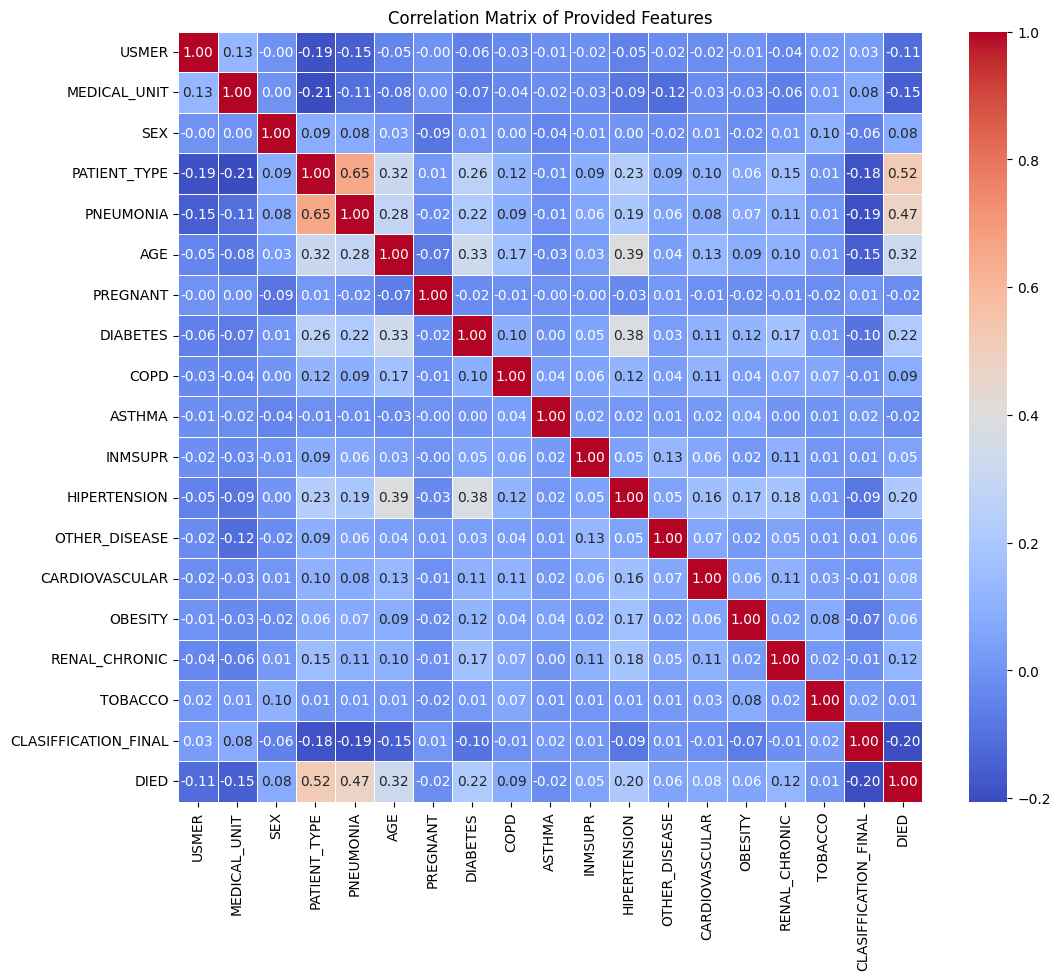

In [65]:
# Calculate the correlation matrix
correlation_matrix = df.corr()

# Set up the matplotlib figure
plt.figure(figsize=(12, 10))

# Generate a heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)

# Add title and display the plot
plt.title('Correlation Matrix of Provided Features')
plt.show()

This code will print the lowest 4 correlated features with the target variable 'DIED'.

In [66]:
# Define the target variable
target_variable = 'DIED'

# Calculate the correlation of all features with the target variable
correlation_with_target = correlation_matrix[target_variable]

# Sort the correlation values by absolute value in ascending order
sorted_correlation = correlation_with_target.abs().sort_values()

# Extract the lowest 4 correlated features
lowest_4_features = sorted_correlation.head(4).index

# Print the lowest 4 correlated features
print("Lowest 4 correlated features with", target_variable, ":\n", lowest_4_features)


Lowest 4 correlated features with DIED :
 Index(['TOBACCO', 'ASTHMA', 'PREGNANT', 'INMSUPR'], dtype='object')


In this case, the variables that have the lowest correlation with 'DIED' are ['TOBACCO', 'ASTHMA', 'INMSUPR', 'PREGNANT']. Thus, we will drop the features that have low correlation with DIED feature.

In [67]:
#filters df so that it contains only the significant variables
df.drop(columns=lowest_4_features, inplace=True)
df.head()

,USMER,MEDICAL_UNIT,SEX,PATIENT_TYPE,PNEUMONIA,AGE,DIABETES,COPD,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,CLASIFFICATION_FINAL,DIED
0,2,1,1,1,1.0,65,0.0,0.0,1.0,0.0,0.0,0.0,0.0,3,1
1,2,1,2,1,1.0,72,0.0,0.0,1.0,0.0,0.0,1.0,1.0,5,1
2,2,1,2,2,0.0,55,1.0,0.0,0.0,0.0,0.0,0.0,0.0,3,1
3,2,1,1,1,0.0,53,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7,1
4,2,1,2,1,0.0,68,1.0,0.0,1.0,0.0,0.0,0.0,0.0,3,1


To encode categorical features, we use OneHotEncode of sklearn

In [68]:
# Encoding the categorical features

from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)

categorical_cols = ["MEDICAL_UNIT", "CLASIFFICATION_FINAL"]
df_categorical = encoder.fit_transform(df[categorical_cols])
categorical_names = encoder.get_feature_names_out(categorical_cols)
df_categorical = pd.DataFrame(df_categorical, columns=categorical_names)

df_categorical.head()

,MEDICAL_UNIT_1,MEDICAL_UNIT_2,MEDICAL_UNIT_3,MEDICAL_UNIT_4,MEDICAL_UNIT_5,MEDICAL_UNIT_6,MEDICAL_UNIT_7,MEDICAL_UNIT_8,MEDICAL_UNIT_9,MEDICAL_UNIT_10,MEDICAL_UNIT_11,MEDICAL_UNIT_12,MEDICAL_UNIT_13,CLASIFFICATION_FINAL_1,CLASIFFICATION_FINAL_2,CLASIFFICATION_FINAL_3,CLASIFFICATION_FINAL_4,CLASIFFICATION_FINAL_5,CLASIFFICATION_FINAL_6,CLASIFFICATION_FINAL_7
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


Then we merge this with the original df

In [69]:
df = df.drop(categorical_cols, axis=1)
df = df.reset_index(drop=True)
df = pd.concat([df, df_categorical], axis=1)

df.head()

,USMER,SEX,PATIENT_TYPE,PNEUMONIA,AGE,DIABETES,COPD,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,...,MEDICAL_UNIT_11,MEDICAL_UNIT_12,MEDICAL_UNIT_13,CLASIFFICATION_FINAL_1,CLASIFFICATION_FINAL_2,CLASIFFICATION_FINAL_3,CLASIFFICATION_FINAL_4,CLASIFFICATION_FINAL_5,CLASIFFICATION_FINAL_6,CLASIFFICATION_FINAL_7
0,2,1,1,1.0,65,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,2,2,1,1.0,72,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,2,2,2,0.0,55,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,2,1,1,0.0,53,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,2,2,1,0.0,68,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0




Shape before dropping columns with NAN:


In [70]:
df.shape

(1048575, 33)



Shape after dropping columns with NAN:


In [71]:
df.dropna(inplace=True)
df.shape

(1025812, 33)


Scaling the Numeric Feature¶


In [72]:
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()
df.AGE = scaler.fit_transform(df.AGE.values.reshape(-1,1))

In [73]:
# Determine X and Y variables

X = df.drop(columns='DIED')
Y = df.DIED

ROC Curve displayer

In [74]:


from sklearn.metrics import roc_curve

# Function that draws an ROC curve
def roc(model, lbl = "Logistic Regression"):
    # Probabilities
    logreg_pred_proba = model.predict_proba(X_test)

    fpr, tpr, thresholds = roc_curve(y_test, logreg_pred_proba[:,1])
    plt.plot([0,1],[0,1],"k--")
    plt.plot(fpr, tpr, label = lbl)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(lbl + " ROC Curve")
    plt.show()



Confusion Matrix Displayer

In [75]:


# Function that draws a confusion matrix given a test and prediction set
def draw_matrix(y_test, y_pred):
    confusion_df = pd.DataFrame(confusion_matrix(y_test, y_pred))
    confusion_df = confusion_df / confusion_df.sum().sum()
    confusion_df = confusion_df.reset_index().melt(id_vars=['index'], value_name='%', var_name='Predicted')
    confusion_df = confusion_df.rename(columns={'index': 'Actual'})

    heatmap = alt.Chart(confusion_df).mark_rect().encode(
        x=alt.X('Predicted:N', sort=list(confusion_df['Predicted'].unique())),
        y=alt.Y('Actual:N', sort=list(confusion_df['Actual'].unique())),
        color=alt.Color('%:Q', scale=alt.Scale(scheme='reds'))
    )
    text = heatmap.mark_text(baseline='middle').encode(
        text=alt.Text('%:Q', format='.2%'),
        color=alt.condition(
            alt.datum.Count > confusion_df['%'].max() / 2,
            alt.value('white'),
            alt.value('black')
        )
    )

    return heatmap.properties(width=300, height=300) + text



Train-Test Split

In [76]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

print("Train_x :", X_train.shape)
print("Test_x :", X_test.shape)
print("Train_y :", y_train.shape)
print("Test_y :", y_test.shape)

print(y_train.value_counts())
print(y_test.value_counts())



Train_x : (820649, 32)
Test_x : (205163, 32)
Train_y : (820649,)
Test_y : (205163,)
0    760642
1     60007
Name: DIED, dtype: int64
0    190375
1     14788
Name: DIED, dtype: int64


We use DecisionTreeClassifier as our model

In [95]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

Training Accuracy

In [96]:
y_pred = clf.predict(X_train)

# calculate the accuracy of the model on training data
accuracy = accuracy_score(y_train, y_pred)
accuracy

0.9626941603535738


Testing Accuracy

In [97]:
y_pred = clf.predict(X_test)

# calculate the accuracy of the model on test data
accuracy = accuracy_score(y_test, y_pred)
accuracy

0.9328095221847994

F1-Score

In [98]:
f1_score(y_test, y_pred)

0.48611369990680336

In [99]:
draw_matrix(y_test, y_pred)

alt.LayerChart(...)

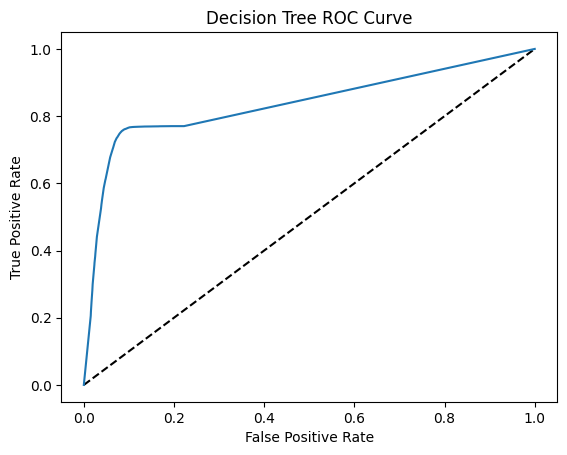

In [100]:
roc(clf, "Decision Tree")

In [101]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.97      0.96    190375
           1       0.54      0.44      0.49     14788

    accuracy                           0.93    205163
   macro avg       0.75      0.71      0.73    205163
weighted avg       0.93      0.93      0.93    205163

